# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
import scipy.signal as signal
import random 
import pywt
from sklearn.cross_decomposition import CCA

# Setup

In [2]:
# Filtering parameters

low_freq = 5
high_freq = 40
sampling_rate = 250

b, a = signal.butter(4, [low_freq, high_freq], fs=sampling_rate, btype='band')

# We load the additional info with load_ssvep_additional_info and get the indexes and names of all aoccipital electrodes
# We also establish the sampling rate and the number of samples without a stimulus flickering.

sampling_rate = 250
data_frequencies, electrodes_names = utils.load_ssvep_additional_info("Dataset BETA/S1")
occipital_electrodes, occipital_electrodes_indexes, occipital_electrodes_names = utils.select_occipital_electrodes(electrodes_names)

samples_without_stimulus = int(0.5 * sampling_rate)

# Initial Analysis

Here we will perform an initial analysis using PSDA and CCA in order to establish which subjects exhibit the "best" response to the stimuli and which subjects exhibit the "worst" response to the stimuli as well as to what frequencies they respond better and which electrodes provide the best results. With this analysis we will have the information that we need to decide which subject, electrode and frequency to choose for our sequential analysis depending on our needs.

## Power Spectra Density Analysis (PSDA)

The first analysis we will perform consistes on identifying wether or not the highest peak in the power spectra corresponds to the stimulus frequency. If it does we consider the stimulus to be correctly detected.

First we will simply obtain the detected frequency using FFT for all subjects using all electrodes for each trial and stimulus frequency.

In [8]:
psda_results = []
for s in range(1,71):

    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",s)

    subject_result = []

    for electrode in range(64):

        channel_result = []

        for trial in range(4):

            trial_result = []

            for frequency in range(40):

                filtered_eeg = signal.lfilter(b, a, eeg_data[electrode, :, trial, frequency])

                fft_result = np.fft.fft(filtered_eeg)
                freq = np.fft.fftfreq(len(filtered_eeg), d=1/sampling_rate)
                power_spectra = np.abs(fft_result) ** 2

                trial_result.append(np.abs(freq[np.argmax(power_spectra)]))
            
            channel_result.append(trial_result)

        subject_result.append(channel_result)
    
    psda_results.append(subject_result)

Now, let's take a look at the overall detection accuracy for each subject. To do this, we will look for the highest number of detections among all trials using all electrodes. We will create a table where we will se the maximum accuracy for each trial in different columns. We will also add an additional column displaying the overall maximum accuracy.

In [9]:
psda_results = np.array(psda_results)
print(psda_results.shape)

table = np.zeros((70, 5)) # 70 subjects and 5 columns
for s in range(70):
    result = np.zeros(5)
    for tr_idx in range(4):
        for e_idx in range(64):
            count = 0
            for f_idx in range(40):
                if psda_results[s, e_idx, tr_idx, f_idx] % data_frequencies[f_idx] == 0:
                    count += 1
            if result[tr_idx] < count:
                result[tr_idx] = count
    result[-1] = max(result)
    table[s] = result

(70, 64, 4, 40)


We will display the results in a table with the number of detections at each trail and the maximum overall number of detections. We colop in green numbers higher or equal to five and in red those lower than five for an easier visual interpretation.

In [10]:
def color_higher_eq_five(val):
    if val >= 5:
        return 'color: green'
    else:
        return 'color: red'
    
rows = []
for s in range(70):
    rows.append("Subject "+str(s+1))
df = pd.DataFrame(table, index=rows, columns = ["T1", "T2", "T3", "T4", "MAX"])
styled_df = df.style.applymap(color_higher_eq_five)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_28709/1515966114.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_higher_eq_five)


,T1,T2,T3,T4,MAX
Subject 1,7,7,6,8,8
Subject 2,5,4,6,4,6
Subject 3,7,8,7,8,8
Subject 4,1,1,2,1,2
Subject 5,3,2,4,2,4
Subject 6,5,4,5,5,5
Subject 7,4,4,3,4,4
Subject 8,5,2,4,4,5
Subject 9,7,7,6,7,7
Subject 10,4,5,5,4,5


When we examined the results independently we noticed that only the stimulus frequencies of 8, 9, 10, 11, 12, 13, 14 and 15 were being detected.

In [11]:
detected_frequencies = np.zeros(40)

table = np.zeros((70, 5)) # 70 subjects and 5 columns
for s in range(70):
    result = np.zeros(5)
    for tr_idx in range(4):
        for e_idx in range(64):
            for f_idx in range(40):
                if psda_results[s, e_idx, tr_idx, f_idx] % data_frequencies[f_idx] == 0:
                    detected_frequencies[f_idx] = 1

for i in range(40):
    if detected_frequencies[i] == 1:
        print(str(data_frequencies[i]), "Hz was detected")

9.0 Hz was detected
10.0 Hz was detected
11.0 Hz was detected
12.0 Hz was detected
13.0 Hz was detected
14.0 Hz was detected
15.0 Hz was detected
8.0 Hz was detected


## Modified PSDA

In order to see if we can obtain more information on the quality of the response to the rest of the stimulus frequencies we have modified our approach so that instead of looking for perfect matches between our maximum peak and the stimulus frequency, we will look for the stimulus frequency closest to our detected peak and choose that one as our detected frequency instead.

In [12]:
psda_modifed_results = []
for s in range(1,71):

    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",s)

    subject_result = []

    for electrode in range(64):

        channel_result = []

        for trial in range(4):

            trial_result = []

            for frequency in range(40):

                filtered_eeg = signal.lfilter(b, a, eeg_data[electrode, :, trial, frequency])

                fft_result = np.fft.fft(filtered_eeg)
                freq = np.fft.fftfreq(len(filtered_eeg), d=1/sampling_rate)
                power_spectra = np.abs(fft_result) ** 2
                                
                peak = np.abs(freq[np.argmax(power_spectra)])

                detected_frequency = 0
                min_module = 100000
                for i in range(40):
                    if peak % data_frequencies[i] < min_module:
                        detected_frequency = data_frequencies[i]
                        min_module = peak % detected_frequency
                
                trial_result.append(detected_frequency)
            
            channel_result.append(trial_result)

        subject_result.append(channel_result)
    
    psda_modifed_results.append(subject_result)

In [13]:
psda_modifed_results = np.array(psda_modifed_results)
print(psda_modifed_results.shape)

table = np.zeros((70, 5)) # 70 subjects and 5 columns
for s in range(70):
    result = np.zeros(5)
    for tr_idx in range(4):
        for e_idx in range(64):
            count = 0
            for f_idx in range(40):
                if psda_modifed_results[s, e_idx, tr_idx, f_idx] == data_frequencies[f_idx]:
                    count += 1
            if result[tr_idx] < count:
                result[tr_idx] = count
    result[-1] = max(result)
    table[s] = result

(70, 64, 4, 40)


Here we have the resulting table with the detections per trial. As can be seen, now we have results with more than 8 detections which indicates that now we are detecting frequencies outside of the group mentioned before. We apply the same coloring to clearly see the improvement in the number of detections.

In [14]:
rows = []
for s in range(70):
    rows.append("Subject "+str(s+1))
df = pd.DataFrame(table, index=rows, columns = ["T1", "T2", "T3", "T4", "MAX"])
styled_df = df.style.applymap(color_higher_eq_five)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_28709/4243353774.py:5: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_higher_eq_five)


,T1,T2,T3,T4,MAX
Subject 1,18,16,17,22,22
Subject 2,10,8,9,10,10
Subject 3,17,17,15,18,18
Subject 4,3,4,4,5,5
Subject 5,6,7,7,6,7
Subject 6,15,10,8,9,15
Subject 7,10,7,8,9,10
Subject 8,12,10,10,7,12
Subject 9,15,17,16,18,18
Subject 10,9,15,12,10,15


Now, let's take a look at which frequencies are being detected for each subject. This will give us more information on the quality of the response of each subject for all stimulus frequencies. 

We will obtain a bar plot showing the overall number of detections of each frequency and then, since showing all of them would take too much space, we will show which frequencies are detected or not by a single subject. We can change the subject number to see the results for the rest when needed.


In [15]:
table = np.zeros(40)
for i in range(40):
    if psda_modifed_results[17, 60, 0, i] == data_frequencies[i]:
        table[i] = 1

In [16]:
s = 63
result = np.zeros((4, 40))
for tr_idx in range(4):
    for f_idx in range(40):
        #result[tr_idx][f_idx] = psda_modifed_results[s, e_idx, tr_idx, f_idx]
        if psda_modifed_results[s, 61, tr_idx, f_idx] == data_frequencies[f_idx]:
            result[tr_idx][f_idx] = 1

Here we are generating the bar plot

In [17]:
# Bar plot
freqs_bars = np.zeros(40)
for s in range(70):
    for tr_idx in range(4):
        for f_idx in range(40):
            #result[tr_idx][f_idx] = psda_modifed_results[s, e_idx, tr_idx, f_idx]
            if psda_modifed_results[s, 61, tr_idx, f_idx] == data_frequencies[f_idx]:
                freqs_bars[f_idx] += 1

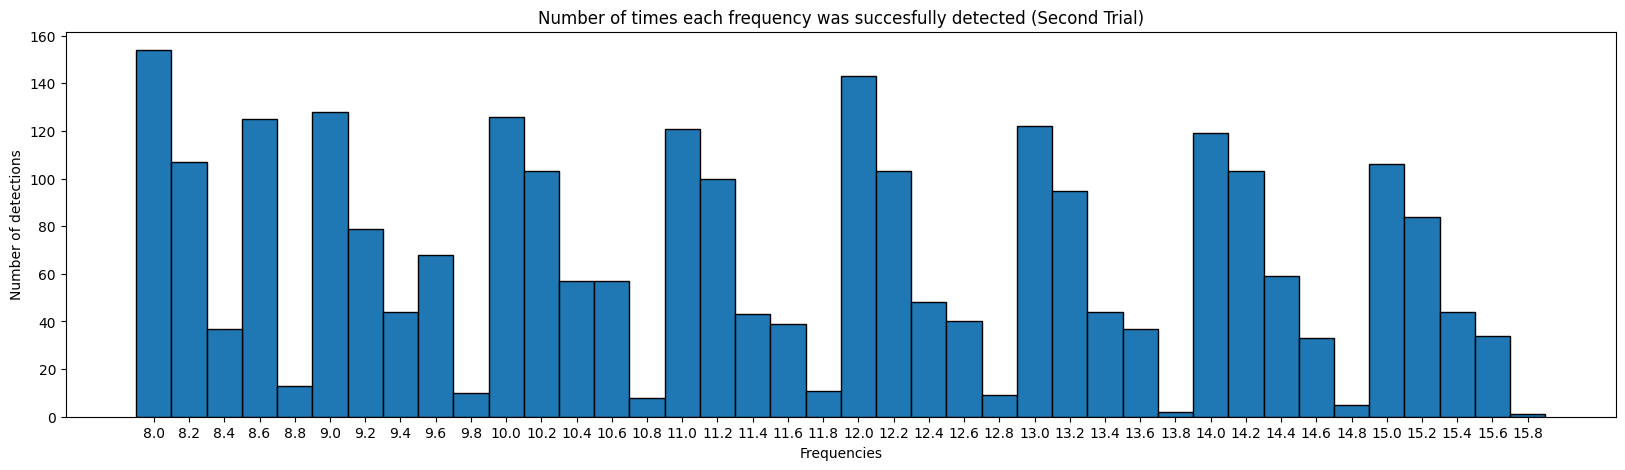

In [18]:
# Create bar plot
plt.figure(figsize=(20,5))
plt.bar(data_frequencies, freqs_bars, width=0.2, edgecolor="black")

# Add labels and title
plt.xlabel('Frequencies')
plt.xticks(data_frequencies)
plt.ylabel('Number of detections')
plt.title('Number of times each frequency was succesfully detected (Second Trial)')

# Show the plot
plt.show()

This is a table view of the detected frequencies for each trial. What we do is we color in red the ones that weren't detected and mark them as 0 while we color in green those that were detected and we mark them as 1.

In [19]:
df = pd.DataFrame(result, index=["T1", "T2", "T3", "T4"], columns = data_frequencies)
styled_df = df.style.applymap(utils.color_numbers_true_false)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_28709/1495816638.py:2: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(utils.color_numbers_true_false)


,8.600000,8.800000,9.000000,9.200000,9.400000,9.600000,9.800000,10.000000,10.200000,10.400000,10.600000,10.800000,11.000000,11.200000,11.400000,11.600000,11.800000,12.000000,12.200000,12.400000,12.600000,12.800000,13.000000,13.200000,13.400000,13.600000,13.800000,14.000000,14.200000,14.400000,14.600000,14.800000,15.000000,15.200000,15.400000,15.600000,15.800000,8.000000,8.200000,8.400000
T1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
T2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This is the same data in a list format

In [21]:
for tr in range(4):
    detected = []
    non_detected = []
    for f in range(40):
        if result[tr][f] == 1:
            detected.append(data_frequencies[f])
        else:
            non_detected.append(data_frequencies[f])
    print("---")
    print("Trial ", tr + 1, ": ")
    print("Detected: ", detected)
    print("Non detected: ", non_detected)

---
Trial  1 : 
Detected:  [11.0, 11.2, 14.200000000000001]
Non detected:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4, 13.600000000000001, 13.8, 14.0, 14.4, 14.600000000000001, 14.8, 15.0, 15.200000000000001, 15.4, 15.600000000000001, 15.8, 8.0, 8.2, 8.4]
---
Trial  2 : 
Detected:  [12.2]
Non detected:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4, 13.600000000000001, 13.8, 14.0, 14.200000000000001, 14.4, 14.600000000000001, 14.8, 15.0, 15.200000000000001, 15.4, 15.600000000000001, 15.8, 8.0, 8.2, 8.4]
---
Trial  3 : 
Detected:  [12.0]
Non detected:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.2, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4,

## CCA

Now we will perform the CCA analysis to get a different perspective with a more sophisticated approach.

In [ ]:
def find_correlation(data, reference_signals, data_frequencies):
    cca = CCA(n_components=1)
    max_correlation = -np.inf
    most_correlated_frequency = None
    
    for i, ref_signal_set in enumerate(reference_signals):
        X = np.array(ref_signal_set).reshape(-1, 12)  # Reshape reference signals
        Y = data.T  # Transpose EEG data if necessary
        
        cca.fit(X, Y)
        x_scores, y_scores = cca.transform(X, Y)
        correlation = np.corrcoef(x_scores[:, 0], y_scores[:, 0])[0, 1]
        
        if correlation > max_correlation:
            max_correlation = correlation
            most_correlated_frequency = i
    
    return data_frequencies[most_correlated_frequency], max_correlation

In [ ]:


electrode_idx = 61 #Electrode Oz

cca_results = np.ones((70, 4, 40)) * -1

for subject in range(1,71):
    
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)

    duration = eeg_data.shape[1]/sampling_rate
    ref_signals = []
    for i in range(40):
        aux = np.array(utils.generate_ref_signal(data_frequencies[i], sampling_rate, duration, 6, 0))
        ref_signals.append(aux)
    ref_signals = np.array(ref_signals)

    for trial_idx in range(4):

        for freq_idx in range(40):

            filtered_eeg = signal.lfilter(b, a, eeg_data[electrode_idx, : , trial_idx, freq_idx])

            prediction, _ = find_correlation(filtered_eeg, ref_signals, data_frequencies)
            cca_results[subject-1, trial_idx, freq_idx] = prediction



In [ ]:
table_cca = np.zeros((70, 5))

for subject in range(70):
    for trial_index in range(4):
        for freq_index in range(40):
            if cca_results[subject, trial_index, freq_index] == data_frequencies[freq_index]:
                table_cca[subject, trial_index] += 1

    table_cca[subject, 0] = table_cca[subject, 0]*100/40
    table_cca[subject, 1] = table_cca[subject, 1]*100/40
    table_cca[subject, 2] = table_cca[subject, 2]*100/40
    table_cca[subject, 3] = table_cca[subject, 3]*100/40
    table_cca[subject, 4] = max(max(table_cca[subject, 0], table_cca[subject, 1]), max(table_cca[subject, 2], table_cca[subject, 3]))

We apply different colors to make the visualization of the best and worst subects easier. This is the color code:

- Blue: 100% detection
- Green: > 75% detection
- Yellow: > 50% detection
- Orange: > 25% detection
- Red: otherwise

In [ ]:
def color_cca(val):
    if val == 100:
        return 'color: blue'
    elif val >= 75:
        return 'color: green'
    elif val >= 50:
        return 'color: yellow'
    elif val >= 25:
        return 'color: orange'
    else:
        return 'color: red'
    
rows = []
for s in range(70):
    rows.append("Subject "+str(s+1))
df = pd.DataFrame(table_cca, index=rows, columns = ["T1", "T2", "T3", "T4", "MAX"])
styled_df = df.style.applymap(color_cca)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_938/3961478790.py:17: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_cca)


,T1,T2,T3,T4,MAX
Subject 1,82,82,85,98,98
Subject 2,30,28,15,28,30
Subject 3,90,80,85,88,90
Subject 4,22,22,30,22,30
Subject 5,25,15,15,10,25
Subject 6,48,30,32,35,48
Subject 7,15,22,25,18,25
Subject 8,42,40,42,58,58
Subject 9,82,82,72,72,82
Subject 10,60,72,68,55,72


# Sliding windows

In [3]:
window_length = int(750/3) #We chose 750 because it is the shortest trial duration
window_step = 10 #int(750/24)

print("Window length = ",window_length)
print("Window step = ", window_step)
print("Number of steps = ", len(np.arange(0, 750, step=window_step)), " and ", len(np.arange(0, 1000, step=window_step)))

Window length =  250
Window step =  10
Number of steps =  75  and  100


In [4]:
# Creating an array with the article's ITRs for each subject
subjects_ITR = [139.63, 148.49, 143.02, 98.37, 134.44, 85.97, 120.77, 87.48, 132.28, 77.22,
                 32.30, 136.97, 125.03, 103.00, 131.44, 94.84, 54.38, 182.66, 116.83, 73.09, 
                 136.39, 122.74, 192.63, 109.57, 105.62, 84.67, 120.75, 116.35, 109.42, 117.79, 
                 64.19, 72.39, 61.61, 128.43, 120.96, 131.44, 148.84, 72.80, 100.83, 87.37, 
                 38.64, 132.80, 82.46, 46.05, 94.24, 84.49, 58.15, 144.17, 180.56, 75.67, 
                 99.62, 136.78, 78.14, 86.02, 33.68, 138.09, 132.46, 113.79, 54.76, 111.07, 
                 48.94, 89.35, 163.57, 81.16, 56.19, 150.49, 207.16, 117.60, 112.14, 123.50]

## Modified PSDA sliding windows

Here we include the code to perform our modified PSDA method with a sliding windows approach to establish when the method detects the stimulus correctly.

In [5]:
electrode_idx = 61 #Electrode Oz

sliding_detections_m_psda = np.ones((70, 4, 40)) * -1

for subject in range(1,71):
    
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",subject)

    max_length = len(eeg_data[electrode_idx, :, 0, 0])

    for trial_idx in range(4):

        for freq_idx in range(40):

            detected = False

            ini = int(250*0.5)
            end = ini + window_length

            filtered_eeg = signal.lfilter(b, a, eeg_data[electrode_idx, : , trial_idx, freq_idx])

            fft_result = np.fft.fft(filtered_eeg)
            freq = np.fft.fftfreq(len(filtered_eeg), d=1/sampling_rate)
            power_spectra = np.abs(fft_result) ** 2

            result = np.abs(freq[np.argmax(power_spectra)])

            step = 0

            while(detected == False and end < max_length):

                filtered_eeg = signal.lfilter(b, a, eeg_data[electrode_idx, ini:end, trial_idx, freq_idx])

                fft_result = np.fft.fft(filtered_eeg)
                freq = np.fft.fftfreq(len(filtered_eeg), d=1/sampling_rate)
                power_spectra = np.abs(fft_result) ** 2

                peak = np.abs(freq[np.argmax(power_spectra)])

                detected_frequency = 0
                min_module = 100000
                for i in range(40):
                    if peak % data_frequencies[i] < min_module:
                        detected_frequency = data_frequencies[i]
                        min_module = peak % detected_frequency

                if detected_frequency == data_frequencies[freq_idx]:
                    detected = True
                    sliding_detections_m_psda[subject-1, trial_idx, freq_idx] = ini

                ini += window_step
                end += window_step
                step += 1



The execution of the sliding windows codes takes a while, specially for the CCA approach. To make it easier to retrieve the data for visualization we created loading and storing functions so that we can save the results in separate file and load it when we need it.

In [6]:
#Store the data into a file using the utils function for it
utils.store_data("Saved data/sliding_m_psda.h5", sliding_detections_m_psda)

Data stored succesfully in sliding_m_psda.h5


In [ ]:

def not_minus_one(val):
    if val != -1:
        return 'color: green'
    else:
        return 'color: red'
    
df = pd.DataFrame(sliding_detections_m_psda[54, :, :], index=["T1", "T2", "T3", "T4"], columns = data_frequencies)
styled_df = df.style.applymap(not_minus_one)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)


/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/3480898211.py:8: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(not_minus_one)


,8.600000,8.800000,9.000000,9.200000,9.400000,9.600000,9.800000,10.000000,10.200000,10.400000,10.600000,10.800000,11.000000,11.200000,11.400000,11.600000,11.800000,12.000000,12.200000,12.400000,12.600000,12.800000,13.000000,13.200000,13.400000,13.600000,13.800000,14.000000,14.200000,14.400000,14.600000,14.800000,15.000000,15.200000,15.400000,15.600000,15.800000,8.000000,8.200000,8.400000
T1,125,-1,125,-1,-1,-1,-1,205,-1,-1,-1,-1,125,-1,595,-1,-1,175,-1,-1,495,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,545,-1,-1,505,-1,-1
T2,315,-1,295,-1,-1,-1,-1,125,-1,-1,-1,-1,135,-1,-1,-1,-1,225,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,545,-1,-1,-1,-1,275,-1,-1
T3,135,-1,215,-1,-1,-1,-1,185,-1,-1,-1,-1,125,-1,-1,-1,-1,365,-1,-1,-1,-1,145,-1,-1,-1,-1,435,-1,-1,-1,-1,685,-1,-1,-1,-1,145,-1,515
T4,185,-1,155,-1,-1,-1,-1,295,-1,-1,-1,-1,125,-1,-1,-1,-1,345,-1,-1,-1,-1,-1,-1,-1,-1,-1,615,-1,-1,-1,-1,175,-1,-1,-1,-1,215,-1,-1


In [ ]:
table_m_psda = np.zeros((70, 3))

for subject in range(70):
    time = 0
    accuracy = 0
    for trial in range(4):
        
        for f in range(40):
            if sliding_detections_m_psda[subject, trial, f] != -1:
                time += sliding_detections_m_psda[subject, trial, f]/sampling_rate
                accuracy += 1
            #elif subject < 15:
            #    time += 75
            #else:
            #    time += 100
    table_m_psda[subject, 0] = time/accuracy
    table_m_psda[subject, 1] = accuracy*100/160
    table_m_psda[subject, 2] = subjects_ITR[subject]
    


def color_condition(val, threshold, color_1, color_2):
    if val >= threshold:
        return 'color: '+color_1
    else:
        return 'color: '+color_2
    
df = pd.DataFrame(table_m_psda, index=range(1, 71), columns = ["Average time", "Accuracy %", "ITR"])
styled_df = df.style.applymap(not_minus_one)

styled_df = df.style.applymap(lambda x: color_condition(x, 10, 'red', 'green'), subset=['Average time'])
styled_df = styled_df.applymap(lambda x: color_condition(x, 20, 'green', 'red'), subset=['Accuracy %'])
styled_df = styled_df.applymap(lambda x: color_condition(x, 100, 'green', 'red'), subset=['ITR'])

formatted_df = styled_df.format(formatter="{:.2f}")
display(formatted_df)



/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/1162712481.py:29: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(not_minus_one)
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/1162712481.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(lambda x: color_condition(x, 10, 'red', 'green'), subset=['Average time'])
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/1162712481.py:32: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: color_condition(x, 20, 'green', 'red'), subset=['Accuracy %'])
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/1162712481.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: color_condition(x, 100, 'green', 'red'), subset=['ITR'])


,Average time,Accuracy %,ITR
1,0.37,31.88,139.63
2,0.61,26.88,148.49
3,0.37,30.62,143.02
4,0.78,16.25,98.37
5,0.80,16.25,134.44
6,0.42,26.88,85.97
7,0.76,18.75,120.77
8,0.63,23.12,87.48
9,0.45,25.00,132.28
10,0.45,24.38,77.22


In [ ]:
T = 0.55
M = 40

my_ITR_m_psda = []
for subject in range(70):
    P = table_m_psda[subject, 1]/100
    t = table_m_psda[subject, 0]
    if P == 1: P = 0.999999999
    value = 60 * (np.log(M) + P * np.log(P) + (1 - P) * np.log((1 - P) / (M - 1))) / (T + t)
    my_ITR_m_psda.append(value)



final_table_m_psda = np.hstack((table_m_psda, np.array(my_ITR_m_psda)[:, np.newaxis]))

df = pd.DataFrame(final_table_m_psda, index=range(1, 71), columns = ["Average time", "Accuracy %", "Article ITR", "My ITR"])
styled_df = df.style.applymap(not_minus_one)

styled_df = df.style.applymap(lambda x: color_condition(x, 1, 'red', 'green'), subset=['Average time'])
styled_df = styled_df.applymap(lambda x: color_condition(x, 20, 'green', 'red'), subset=['Accuracy %'])
styled_df = styled_df.applymap(lambda x: color_condition(x, 100, 'green', 'red'), subset=['Article ITR'])
styled_df = styled_df.applymap(lambda x: color_condition(x, 100, 'green', 'red'), subset=['My ITR'])

formatted_df = styled_df.format(formatter="{:.2f}")
display(formatted_df)



/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/731191277.py:17: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(not_minus_one)
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/731191277.py:19: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(lambda x: color_condition(x, 1, 'red', 'green'), subset=['Average time'])
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/731191277.py:20: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: color_condition(x, 20, 'green', 'red'), subset=['Accuracy %'])
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_34169/731191277.py:21: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: color_condition(x, 100, 'green', 'red'), subset=['Article ITR'])
/

,Average time,Accuracy %,Article ITR,My ITR
1,0.37,31.88,139.63,37.07
2,0.61,26.88,148.49,22.08
3,0.37,30.62,143.02,34.46
4,0.78,16.25,98.37,7.97
5,0.80,16.25,134.44,7.87
6,0.42,26.88,85.97,26.56
7,0.76,18.75,120.77,10.54
8,0.63,23.12,87.48,16.83
9,0.45,25.00,132.28,22.82
10,0.45,24.38,77.22,21.78


## CCA sliding windows

Here we include the code to perform CCA with a sliding windows approach to establish when the method detects the stimulus correctly.

In [ ]:
def find_correlation(data, reference_signals, data_frequencies):
    cca = CCA(n_components=1)
    max_correlation = -np.inf
    most_correlated_frequency = None
    
    for i, ref_signal_set in enumerate(reference_signals):
        X = np.array(ref_signal_set).reshape(-1, 12)  # Reshape reference signals
        Y = data.T  # Transpose EEG data if necessary
        
        cca.fit(X, Y)
        x_scores, y_scores = cca.transform(X, Y)
        correlation = np.corrcoef(x_scores[:, 0], y_scores[:, 0])[0, 1]
        
        if correlation > max_correlation:
            max_correlation = correlation
            most_correlated_frequency = i
    
    return data_frequencies[most_correlated_frequency], max_correlation

In [ ]:
duration = window_length/sampling_rate
ref_signals = []
for i in range(40):
    aux = np.array(utils.generate_ref_signal(data_frequencies[i], sampling_rate, duration, 6, 0))
    ref_signals.append(aux)
ref_signals = np.array(ref_signals)

In [ ]:
sliding_detections_cca = []

electrode_idx = 61 #Electrode Oz

sliding_detections_cca = np.ones((70, 4, 40)) * -1

for subject in range(1,71):
    
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("Dataset BETA/",subject)

    max_length = len(eeg_data[electrode_idx, :, 0, 0])

    for trial_idx in range(4):

        for freq_idx in range(40):

            detected = False

            ini = int(250 * 0.5)
            end = ini + window_length

            filtered_eeg = signal.lfilter(b, a, eeg_data[electrode_idx, : , trial_idx, freq_idx])

            step = 0

            while(detected == False and end < max_length):

                prediction, _ = find_correlation(filtered_eeg[ini:end], ref_signals, data_frequencies)
                if prediction == data_frequencies[freq_idx]:
                    detected = True
                    sliding_detections_cca[subject-1, trial_idx, freq_idx] = ini
                
                ini += window_step
                end += window_step
                step += 1



In [ ]:
#Store the data into a file

utils.store_data("Saved data/sliding_cca.h5", sliding_detections_cca)

Data stored succesfully in sliding_cca.h5


In [ ]:

def not_minus_one(val):
    if val != -1:
        return 'color: green'
    else:
        return 'color: red'
    
df = pd.DataFrame(sliding_detections_cca[17, :, :], index=["T1", "T2", "T3", "T4"], columns = data_frequencies)
styled_df = df.style.applymap(not_minus_one)
formatted_df = styled_df.format(formatter="{:.0f}")
display(formatted_df)


/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_73952/3459549708.py:8: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(not_minus_one)


,8.600000,8.800000,9.000000,9.200000,9.400000,9.600000,9.800000,10.000000,10.200000,10.400000,10.600000,10.800000,11.000000,11.200000,11.400000,11.600000,11.800000,12.000000,12.200000,12.400000,12.600000,12.800000,13.000000,13.200000,13.400000,13.600000,13.800000,14.000000,14.200000,14.400000,14.600000,14.800000,15.000000,15.200000,15.400000,15.600000,15.800000,8.000000,8.200000,8.400000
T1,255,125,125,175,125,125,125,175,165,125,275,185,185,125,195,145,155,145,125,285,155,135,125,215,125,135,175,145,235,185,145,165,185,135,125,145,-1,125,135,125
T2,155,255,135,135,125,225,185,165,125,165,125,285,165,155,145,135,135,155,175,125,125,275,145,135,125,175,145,135,145,125,175,125,125,165,205,125,205,135,145,125
T3,135,125,125,125,125,125,125,135,165,145,125,665,125,145,135,225,135,125,125,125,125,175,155,175,125,175,125,165,125,145,125,185,145,135,265,125,385,195,125,125
T4,145,215,125,125,165,255,125,125,125,155,145,145,185,135,125,175,125,145,135,165,185,165,155,275,175,155,145,255,265,125,155,205,385,255,175,205,195,135,155,145


In [ ]:
table_cca = np.zeros((70, 3))

for subject in range(70):
    time = 0
    accuracy = 0
    for trial in range(4):
        
        for f in range(40):
            if sliding_detections_cca[subject, trial, f] != -1:
                time += sliding_detections_cca[subject, trial, f]/sampling_rate
                accuracy += 1
            #elif subject < 15:
            #    time += 75
            #else:
            #    time += 100
            
    table_cca[subject, 0] = time/accuracy
    table_cca[subject, 1] = accuracy*100/160
    table_cca[subject, 2] = subjects_ITR[subject]
    


def color_condition(val, threshold, color_1, color_2):
    if val >= threshold:
        return 'color: '+color_1
    else:
        return 'color: '+color_2
    
df = pd.DataFrame(table_cca, index=range(1, 71), columns = ["Average time", "Accuracy %", "ITR"])
styled_df = df.style.applymap(not_minus_one)

styled_df = df.style.applymap(lambda x: color_condition(x, 10, 'red', 'green'), subset=['Average time'])
styled_df = styled_df.applymap(lambda x: color_condition(x, 20, 'green', 'red'), subset=['Accuracy %'])
styled_df = styled_df.applymap(lambda x: color_condition(x, 100, 'green', 'red'), subset=['ITR'])

formatted_df = styled_df.format(formatter="{:.2f}")
display(formatted_df)



/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_73952/3530166524.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(not_minus_one)
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_73952/3530166524.py:32: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(lambda x: color_condition(x, 10, 'red', 'green'), subset=['Average time'])
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_73952/3530166524.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: color_condition(x, 20, 'green', 'red'), subset=['Accuracy %'])
/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_73952/3530166524.py:34: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(lambda x: color_condition(x, 100, 'green', 'red'), subset=['ITR'])


,Average time,Accuracy %,ITR
1,0.64,96.88,139.63
2,0.92,66.25,148.49
3,0.64,97.50,143.02
4,1.02,75.62,98.37
5,1.11,58.75,134.44
6,0.95,63.12,85.97
7,1.14,55.62,120.77
8,0.89,78.75,87.48
9,0.68,96.88,132.28
10,0.76,97.50,77.22


# Synthetic Reference Signals

Here we generate the reference signals. We use the same functions for plotting that we use with our final data. Since this is the final version of the code the label with the shading areas are present even though there will be no shading.

By tweaking the following code we obtained the syntehtic signals with different number of harmonics and without changes in frequency over time. We present only the generated

In [14]:
t = np.arange(0, 750/sampling_rate, 1/sampling_rate)

fundamental_frequency = 13
amplitude = 4
n_harmonics = 3

# Generate the base oscillatory signal
oscillatory_signal = amplitude*np.sin(np.pi * 2 * fundamental_frequency * t)

# Generate the frequencies for the harmonics
harmonic_frequencies = [fundamental_frequency * i for i in range(2, 2 + n_harmonics)] 

# Generate signals for the harmonic frequencies
harmonic_signals = [np.sin(np.pi * 2 * f * t) for f in harmonic_frequencies]

for h in range(len(harmonic_signals)):
    harmonic_signals[h] = harmonic_signals[h]*(amplitude/(h+2))

# Combine the original signal with harmonics
#combined_signal = oscillatory_signal + sum(harmonic_signals)

combined_signal = oscillatory_signal

for h in harmonic_signals:
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    ini = random.randint(0, len(combined_signal) - 200)
    combined_signal[ini:ini+200] += h[ini:ini+200]
    
# Add noise
noise_amplitude = 1
noise = noise_amplitude * np.random.randn(len(combined_signal))
noisy_signal = combined_signal + noise


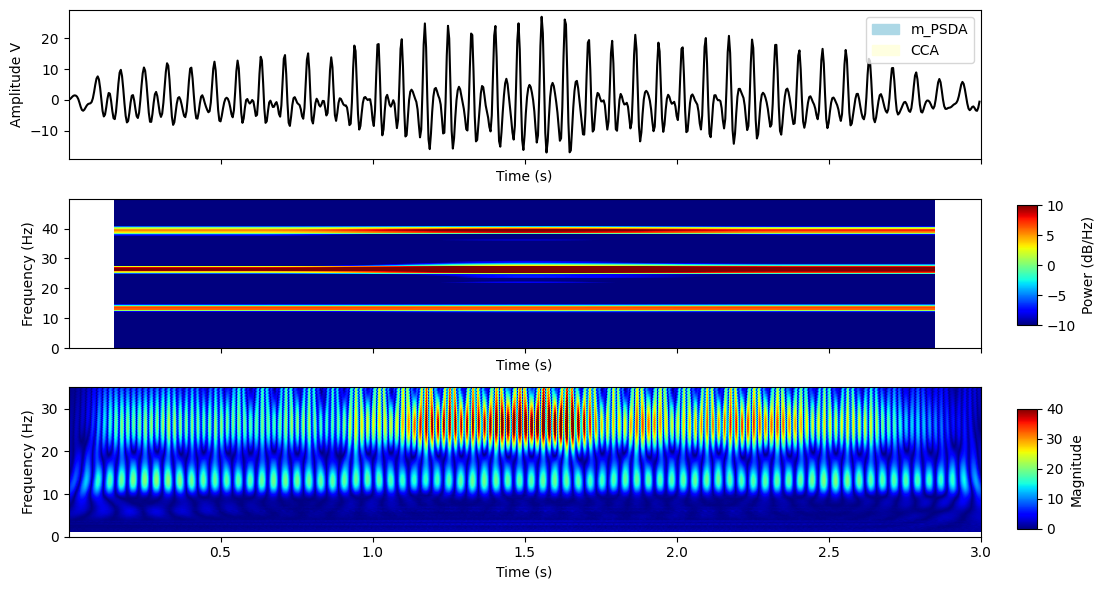

In [15]:
utils.plot_generation_spectrogram_wavelet(noisy_signal, sampling_rate, 0, [10], True, False, "", [-1, -1], 0)

In [16]:
t = np.arange(0, 750/sampling_rate, 1/sampling_rate)

fundamental_frequency = 13
amplitude = 4
n_harmonics = 3

freq_chunk1 = 8
freq_chunk2 = 14

noise_amplitude = 0.8
    
# Define time points for frequency changes
change_point1 = int(len(t) / 3)
change_point2 = int(2 * len(t) / 3)

# Generate sine waves with variable frequencies
signal1 = np.sin(2 * np.pi * freq_chunk1 * t[:change_point1])
signal2 = np.sin(2 * np.pi * freq_chunk2 * t[change_point1:change_point2])*1.2
signal3 = np.sin(2 * np.pi * freq_chunk1 * t[change_point2:])
signal4 = np.sin(2 * np.pi * freq_chunk2 * t[change_point2:])*1.2

# Apply cosine window for smooth transitions
window1 = np.hanning(2 * change_point1)[:change_point1]
window2 = np.hanning(change_point2 - change_point1)
window3 = np.hanning(2 * (len(t) - change_point2))[-(len(t) - change_point2):]

# Combine signals with smooth transitions
combined_signal = np.concatenate([signal1 * window1, signal2 * window2, (signal3 + signal4) * window3])
combined_signal = np.concatenate([signal1, signal2, signal3 + signal4]) * 5

# Add noise
noise = noise_amplitude * np.random.normal(size=len(t)) * 4
noisy_signal = combined_signal + noise



/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_29057/246254613.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


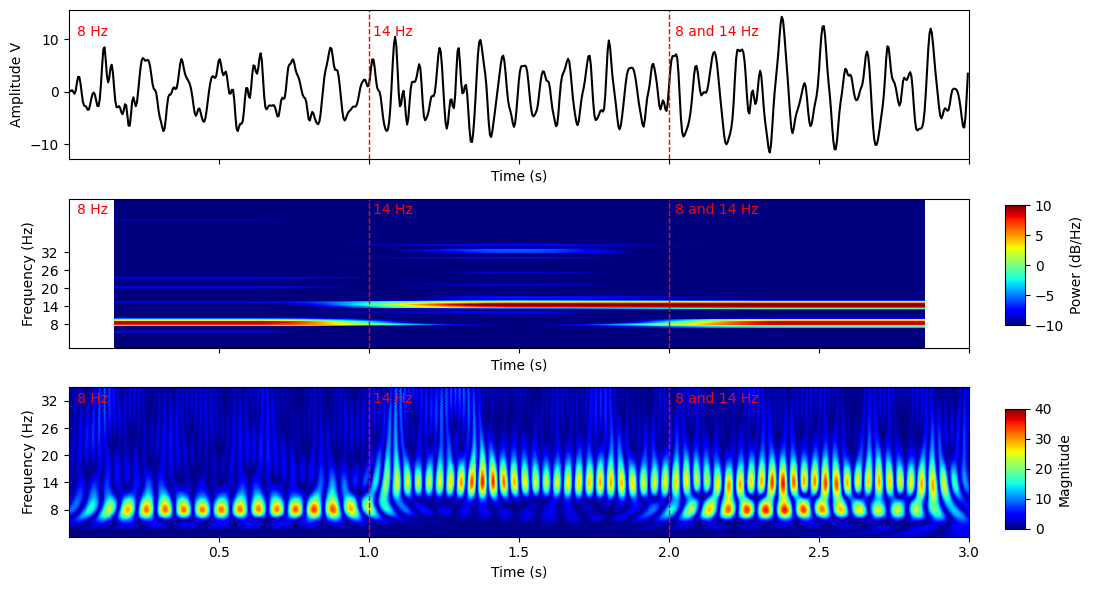

In [17]:
eeg_data = noisy_signal

wavelet_name = "morl" # Morlet

# Filtering
low_freq = 5
high_freq = 40
sampling_rate = 250

b, a = signal.butter(4, [low_freq, high_freq], fs=sampling_rate, btype='band')
filtered_data = signal.lfilter(b, a, eeg_data) 

# Rango de frecuencias a analizar. Hay que dividr por sampling_rate para hacer correctamente el cambio a escala
frequencies = np.arange(1, 40, 0.01) /sampling_rate 
# Pasamos de frecuencias a escalas para utilizarlas en la transformada
scales = pywt.frequency2scale(wavelet_name, frequencies) 
# Transformada Wavelet
cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name) 
# Multiplicamos por samping_rate para recuperar las frecuencias en Hz
frequencies = frequencies*sampling_rate 

t = np.arange(0, len(eeg_data)/sampling_rate, 1/sampling_rate)

# 3 subplots: señal, espectrograma y transformada wavelet
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 6), sharex=True)

ax1.plot(t, filtered_data, 'k')
ax1.set_xlim(0, 4)
if len(eeg_data) < 750:
    ax1.set_xticks([0.5, 1, 1.5, 2, 2.5])
else:
    ax1.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5])
ax1.set_xlim(0, len(eeg_data) / sampling_rate)
ax1.set_ylabel("Amplitude V")
ax1.set_xlabel("Time (s)")

ax1.axvline(x=(change_point1 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk1} Hz')
ax1.axvline(x=(change_point2 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk2} Hz')
ax1.text(0+ 0.08, 10, f'{freq_chunk1} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax1.text((change_point1 / sampling_rate) + 0.08, 10, f'{freq_chunk2} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax1.text((change_point2 / sampling_rate) + 0.16, 10, f'8 and 14 Hz', color='r', va='bottom', ha='center', fontsize=10)

ax2.axvline(x=(change_point1 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk1} Hz')
ax2.axvline(x=(change_point2 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk2} Hz')
ax2.text(0+ 0.08, 44, f'{freq_chunk1} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax2.text((change_point1 / sampling_rate) + 0.08, 44, f'{freq_chunk2} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax2.text((change_point2 / sampling_rate) + 0.16, 44, f'8 and 14 Hz', color='r', va='bottom', ha='center', fontsize=10)

ax3.axvline(x=(change_point1 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk1} Hz')
ax3.axvline(x=(change_point2 / sampling_rate), color='r', linestyle='--', ymin=0, ymax=1, linewidth=1, label=f'{freq_chunk2} Hz')
ax3.text(0+ 0.08, 31, f'{freq_chunk1} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax3.text((change_point1 / sampling_rate) + 0.08, 31, f'{freq_chunk2} Hz', color='r', va='bottom', ha='center', fontsize=10)
ax3.text((change_point2 / sampling_rate) + 0.16, 31, f'8 and 14 Hz', color='r', va='bottom', ha='center', fontsize=10)


# Valore utilizados para mantener la escala de colores del espectrograma
vmin = -10
vmax = 10

Pxx, freqs, bins, im = ax2.specgram(filtered_data, NFFT=300, Fs=sampling_rate, noverlap=int(300/4), cmap='jet', vmin=vmin, vmax=vmax)
f_value = 2
ticks = [8, 14, 20, 26, 32]
ax2.set_yticks(ticks)
if len(eeg_data) < 750:
    ax2.set_xticks([0.5, 1, 1.5, 2, 2.5])
else:
    ax2.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_ylim(0, 50)
# Add colorbar for the spectrogram
cbar_ax2 = fig.add_axes([1.01, 0.45, 0.02, 0.2])  # [left, bottom, width, height]
plt.colorbar(im, cax=cbar_ax2, label='Power (dB/Hz)')

# Valores utilizados para mantener la escala de colores de la transformada wavelet
vmin = 0 
vmax = 40

ax3.imshow(np.abs(cwtmatr), aspect='auto', cmap='jet', extent=[0, len(filtered_data) / sampling_rate, frequencies[-1], frequencies[0]], origin='upper', vmin=vmin, vmax=vmax)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_ylim(2, 35)
#ticks = np.arange(0, 35, step=f_value)
ax3.set_yticks(ticks)
ax3.set_xlim(0, len(eeg_data) / sampling_rate)  # Adjusted x-axis range
cbar_ax3 = fig.add_axes([1.01, 0.11, 0.02, 0.2])
plt.colorbar(ax3.images[0], cax=cbar_ax3, label="Magnitude")

plt.tight_layout()


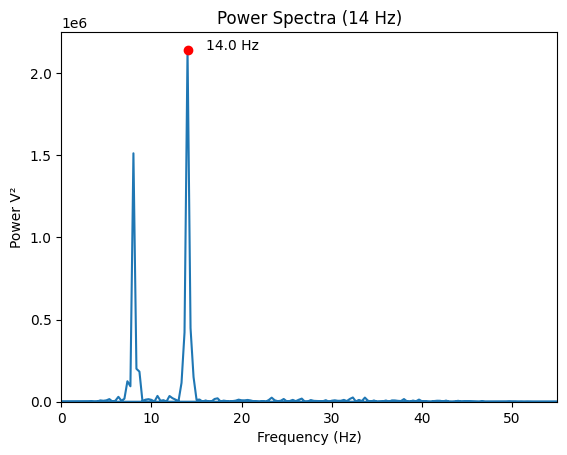

In [18]:
utils.plot_generation_fft(eeg_data, sampling_rate, 14, True, False, "")